# Raster Clipping
AOI definition in vector-based raster clipping and user defined extent-based raster clipping are significantly different. While, vector-based clipping is straight forward, creating AOI based on user-defined extent is tricky since the extent has to be converted to the raster CRS. 
Hence, two different functions are created for each purpose. 

## 1. User defined extent-based Raster clipping

In [1]:
# FOR CLIPPING WITH USER-DEFINED EXTENT
import rasterio as rio
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.plot import show

xmin, ymin, xmax, ymax = 86.1, 23.59, 86.5, 23.84
raster = rio.open('LC08_L1TP_140043_20180109_20180119_01_T1/LC08_L1TP_140043_20180109_20180119_01_T1_B4.TIF')

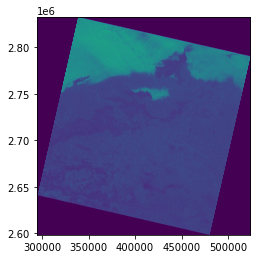

<AxesSubplot:>

In [2]:
show(raster)

In [3]:
def RasClip_extent_manual(ras = raster, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, op_file_name = 'clip_ext_man.tif'):
    
    bbox = box(xmin, ymin, xmax, ymax)
    coords = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    coords = coords.to_crs(crs=raster.crs.data)
    minx = coords.bounds['minx'].min()
    miny = coords.bounds['miny'].min()
    maxx = coords.bounds['maxx'].max()
    maxy = coords.bounds['maxy'].max()

    aoi = [{'type': 'Polygon',
                   'coordinates': [[(minx,miny),
                                    (minx,maxy),
                                    (maxx,maxy),
                                    (maxx,miny),
                                    (minx,miny)]]}]
    
    # applying mask 
    clipped, transform = mask(ras, aoi, crop=True)
    
    # use original metadata
    meta = ras.meta.copy()
    # update the metadata with clipped image metadata
    meta.update({"transform": transform,
                 "height":clipped.shape[1],
                 "width":clipped.shape[2]})
    with rio.open(op_file_name, 'w', **meta) as dst:
        dst.write(clipped)
    return rio.open(op_file_name)

C:\Users\Xplorer\miniconda3\envs\gis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


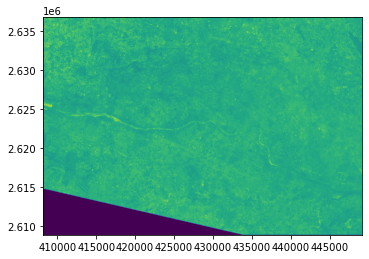

<AxesSubplot:>

In [4]:
ext_manual = RasClip_extent_manual()
show(ext_manual)

## 2. Vector boundary-based Raster clipping


In [5]:
import rasterio as rio
import fiona
from rasterio.mask import mask
from rasterio.plot import show

vector = fiona.open('jcf_utm.shp')
raster = rio.open('LC08_L1TP_140043_20180109_20180119_01_T1/LC08_L1TP_140043_20180109_20180119_01_T1_B4.TIF')

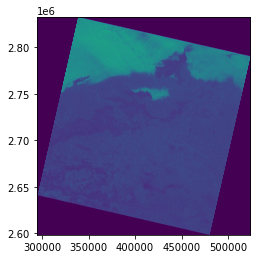

<AxesSubplot:>

In [6]:
show(raster)

In [8]:
def RasClip_vector_boundary(ras = raster, vec = vector, op_file_name = 'clip_vec_bound.tif'):
    # making AOI from external vector
    aoi = [feature["geometry"] for feature in vec]
    
    # applying mask 
    clipped, transform = mask(ras, aoi, crop=True)
    
    # use original metadata
    meta = ras.meta.copy()
    # update the metadata with clipped image metadata
    meta.update({"transform": transform,
                 "height":clipped.shape[1],
                 "width":clipped.shape[2]})
    with rio.open(op_file_name, 'w', **meta) as dst:
        dst.write(clipped)
    return rio.open(op_file_name)

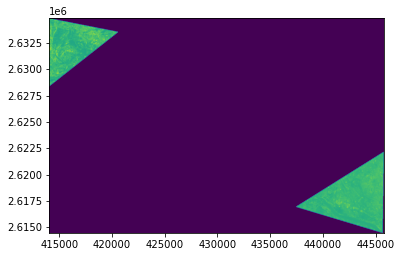

<AxesSubplot:>

In [9]:
vec_based = RasClip_vector_boundary()
show(vec_based)

In [10]:
# Note: Haven't checked if Ras and Vec are of different CRS in this method. Wait for update

## 3. Vector XY limits-based Raster clipping

There is a constraint with <i><b> mask </b></i> function (used in above functions).
Unless the <i> crop </i> parameter is True, actual cropping won't happen (it only masks the outer region). When the parameter is True, it crops according to the boundary of the vector file (not by XY limits). Hence, getting a rectangular crop according to the XY limits of the vector file is not easy.
To achieve it, the function below can be used. It identifies the XY limits and pass them as crop limits. 

In [11]:
# FOR CLIPPING WITH USER-DEFINED EXTENT
import rasterio as rio
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd

vector = gpd.read_file('jcf_utm.shp')
raster = rio.open('LC08_L1TP_140043_20180109_20180119_01_T1/LC08_L1TP_140043_20180109_20180119_01_T1_B4.TIF')

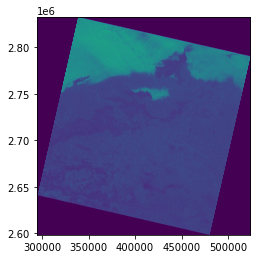

<AxesSubplot:>

In [12]:
show(raster)

<AxesSubplot:>

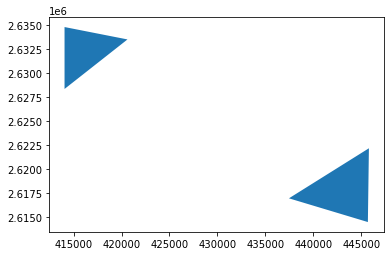

In [13]:
vector.plot()

In [14]:
def RasClip_extent_vector(ras = raster, vec = vector, op_file_name = 'clip_ext_vec.tif'):
    vec_wgs84 = vec.to_crs(4326)
    xmin = vec_wgs84.bounds['minx'].min()
    ymin = vec_wgs84.bounds['miny'].min()
    xmax = vec_wgs84.bounds['maxx'].max()
    ymax = vec_wgs84.bounds['maxy'].max()
    
    # Rest of the computation is same as Raster Clip by providing manual extent
    return RasClip_extent_manual(ras = ras, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, op_file_name = op_file_name)

C:\Users\Xplorer\miniconda3\envs\gis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


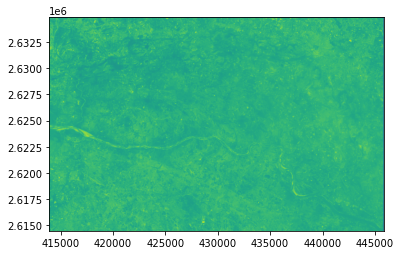

<AxesSubplot:>

In [15]:
ext_vec = RasClip_extent_vector()
show(ext_vec)